In [31]:
import sys
import os
import importlib   

sys.path.append(os.path.join(os.getcwd(), 'NeuralNetworks'))
import Fully_connected_network as FC
importlib.reload(FC)

import torch
import matplotlib.pyplot as plt

In [32]:
if torch.cuda.is_available():
   device = torch.device("cuda")
   print("Running on the GPU")
else:
   device = torch.device("cpu")
   print("Running on the CPU")

torch.manual_seed(12)
torch.set_default_dtype(torch.float64)

Running on the GPU


In [33]:
def u_exact(x:torch.Tensor):
    # u_g = torch.log(x+2) + torch.cos(2*x + x**3)
    u_g = torch.sin(2*x + 1) + 0.2*torch.exp(1.3*x)
    # u_g = x**3/(0.01 + x**4)
    return u_g

In [34]:
def calculate_kappa(x):
    nb_zeros = torch.where(x[:-1, 0] * x[1:, 0] < 0)[0]
    kappa = 3*(nb_zeros.shape[0])
    return kappa

In [44]:
class OneStageFCNN():
    def __init__(self, x_train, u_train, hidden_size, kappa, lower_bound, upper_bound, activation_func):
        super(OneStageFCNN, self).__init__()

        self.u_scale = torch.max(torch.abs(u_train))/2
        self.loss_scale = self.u_scale**2
        self.x_train = x_train
        self.u_train = u_train/self.u_scale

        self.hidden_size = hidden_size
        self.kappa = kappa
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.activation_func = activation_func

        self.model = FC.FullyConnectedNetwork(domain_bounds=[lower_bound, upper_bound], kappa=kappa, input_dim=1, hidden_size=hidden_size, actv=activation_func) 

    def train(self, n_iter):
        loss_criterion = torch.nn.MSELoss()
        model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

        for iter_i in range(n_iter):
            model_optimizer.zero_grad()
            u_pred = self.model(self.x_train)
            loss_value = loss_criterion(u_pred, self.u_train) * self.loss_scale
            loss_value.backward()
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f"Iteration {iter_i}, Loss: {loss_value}")

    def predict(self, x_to_predict):
        u_pred = self.model(x_to_predict) * self.u_scale
        return u_pred



In [37]:
nb_training_points = 1501
x_train = torch.linspace(-1.02, 1.02, nb_training_points).reshape(-1,1)
u_train = u_exact(x_train)

low_bound_xtrain, up_bound_xtrain = x_train.min(), x_train.max()

nb_evaluation_points = 8000
x_eval = torch.linspace(-1, 1, nb_evaluation_points).reshape(-1,1)
u_eval = u_exact(x_eval)

In [45]:
# Fist stage of training

model1 = OneStageFCNN(x_train, u_train, hidden_size=20, kappa=1, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=0)
model1.train(5000)
u_pred = model1.predict(x_eval)

Iteration 0, Loss: 0.8170001911452807
Iteration 100, Loss: 0.07066767814062816
Iteration 200, Loss: 0.03233332544381287
Iteration 300, Loss: 0.0062765159825247585
Iteration 400, Loss: 0.005360343626956225
Iteration 500, Loss: 0.00479407271012683
Iteration 600, Loss: 0.004312709888074212
Iteration 700, Loss: 0.0038935893847209754
Iteration 800, Loss: 0.003515201606107199
Iteration 900, Loss: 0.0031584411190029127
Iteration 1000, Loss: 0.0028085122807355025
Iteration 1100, Loss: 0.0024555623829635555
Iteration 1200, Loss: 0.002094881592574911
Iteration 1300, Loss: 0.001727579208540527
Iteration 1400, Loss: 0.0013616545463514915
Iteration 1500, Loss: 0.0010121287774933398
Iteration 1600, Loss: 0.0006984760734518204
Iteration 1700, Loss: 0.0004393012906415041
Iteration 1800, Loss: 0.0002468293132199628
Iteration 1900, Loss: 0.00012270221975718704
Iteration 2000, Loss: 5.5360564338275e-05
Iteration 2100, Loss: 2.4485918411264035e-05
Iteration 2200, Loss: 1.1728400170763968e-05
Iteration 230

In [47]:
# Second stage of the training

u_train2 = u_train - model1.predict(x_train).detach()
kappa2 = calculate_kappa(u_train2)

model2 = OneStageFCNN(x_train, u_train2, hidden_size=20, kappa=kappa2, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model2.train(5000)
u_pred2 = model2.predict(x_eval)
u_p = u_pred + u_pred2

Iteration 0, Loss: 4.791383142904984e-07
Iteration 100, Loss: 1.2407455337137137e-08
Iteration 200, Loss: 5.392665949919873e-09
Iteration 300, Loss: 3.295702516246056e-09
Iteration 400, Loss: 2.27106860834275e-09
Iteration 500, Loss: 1.6389727146187973e-09
Iteration 600, Loss: 1.1950870468776465e-09
Iteration 700, Loss: 8.740464087089137e-10
Iteration 800, Loss: 6.456964127704942e-10
Iteration 900, Loss: 4.823220520889405e-10
Iteration 1000, Loss: 3.6490077385290697e-10
Iteration 1100, Loss: 2.812394895229824e-10
Iteration 1200, Loss: 2.2250581422923477e-10
Iteration 1300, Loss: 1.817609778456848e-10
Iteration 1400, Loss: 1.5356134784906377e-10
Iteration 1500, Loss: 1.3382931641722722e-10
Iteration 1600, Loss: 1.196800570040291e-10
Iteration 1700, Loss: 1.0917356698814343e-10
Iteration 1800, Loss: 1.0105388930400971e-10
Iteration 1900, Loss: 9.452692964926983e-11
Iteration 2000, Loss: 8.909512518978648e-11
Iteration 2100, Loss: 8.444508976633948e-11
Iteration 2200, Loss: 8.037586571588

In [64]:
# Third stage of the training
nb_training_points_strengthening = 4801
x_train_strengthening = torch.linspace(-1.02, 1.02, nb_training_points_strengthening).reshape(-1,1)
u_train_strengthening = u_exact(x_train_strengthening)

u_train3 = u_train_strengthening - model1.predict(x_train_strengthening).detach() - model2.predict(x_train_strengthening).detach()
kappa3 = calculate_kappa(u_train3)

model3 = OneStageFCNN(x_train_strengthening, u_train3, hidden_size=30, kappa=kappa3, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model3.train(15000)
u_pred3 = model3.predict(x_eval)
u_p2 = u_p + u_pred3

Iteration 0, Loss: 1.5046490640995643e-09
Iteration 100, Loss: 2.449090932532469e-10
Iteration 200, Loss: 8.881767965551983e-11
Iteration 300, Loss: 5.769488387341342e-11
Iteration 400, Loss: 4.7126193795228554e-11
Iteration 500, Loss: 4.1410787440317905e-11
Iteration 600, Loss: 3.7311864975755474e-11
Iteration 700, Loss: 3.416965120930461e-11
Iteration 800, Loss: 3.176183096654086e-11
Iteration 900, Loss: 2.9918731203568505e-11
Iteration 1000, Loss: 2.8476903320876734e-11
Iteration 1100, Loss: 2.730437951639625e-11
Iteration 1200, Loss: 2.630943389217812e-11
Iteration 1300, Loss: 2.543398513379479e-11
Iteration 1400, Loss: 2.464416669714885e-11
Iteration 1500, Loss: 2.3922101805415343e-11
Iteration 1600, Loss: 2.3259085635894796e-11
Iteration 1700, Loss: 2.2650341005286353e-11
Iteration 1800, Loss: 2.2091826356358202e-11
Iteration 1900, Loss: 2.157905506520932e-11
Iteration 2000, Loss: 2.1107169855261093e-11
Iteration 2100, Loss: 2.0671403543315436e-11
Iteration 2200, Loss: 2.02674390

In [66]:
# Fourth stage of the training
u_train4 = u_train_strengthening - model1.predict(x_train_strengthening).detach() - model2.predict(x_train_strengthening).detach() - model3.predict(x_train_strengthening).detach()
kappa4 = calculate_kappa(u_train4)

model4 = OneStageFCNN(x_train_strengthening, u_train4, hidden_size=30, kappa=kappa4, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model4.train(5000)
u_pred4 = model4.predict(x_eval)

u_p3 = u_p2 + u_pred4

Iteration 0, Loss: 3.933113218394097e-10
Iteration 100, Loss: 1.3355094452739976e-10
Iteration 200, Loss: 9.524838475817605e-11
Iteration 300, Loss: 8.434179342146602e-11
Iteration 400, Loss: 7.688600636700382e-11
Iteration 500, Loss: 7.158721243322482e-11
Iteration 600, Loss: 6.742985632830119e-11
Iteration 700, Loss: 6.377820289923897e-11
Iteration 800, Loss: 6.032321664993995e-11
Iteration 900, Loss: 5.698937659522752e-11
Iteration 1000, Loss: 5.3811683592200064e-11
Iteration 1100, Loss: 5.0809344644799824e-11
Iteration 1200, Loss: 4.8015413744989434e-11
Iteration 1300, Loss: 4.5493863926247857e-11
Iteration 1400, Loss: 4.327292261011748e-11
Iteration 1500, Loss: 4.131586164928258e-11
Iteration 1600, Loss: 3.9566048655246804e-11
Iteration 1700, Loss: 3.797839197391848e-11
Iteration 1800, Loss: 3.652245650585758e-11
Iteration 1900, Loss: 3.517686387267058e-11
Iteration 2000, Loss: 3.392476091078906e-11
Iteration 2100, Loss: 3.275228239569309e-11
Iteration 2200, Loss: 3.16484886166869

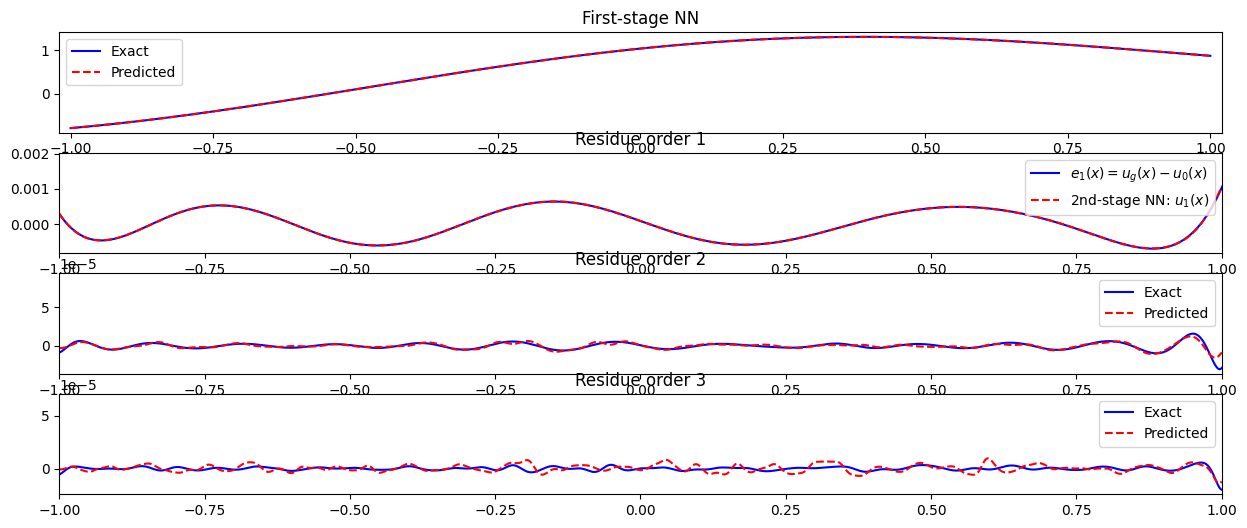

In [67]:
fig, axes = plt.subplots(4, 1, figsize=(15, 6))
axes[0].plot(x_eval, u_eval, 'b-', label='Exact')
axes[0].plot(x_eval, u_pred.detach(), 'r--', label='Predicted')
axes[0].set_xlim(low_bound_xtrain, up_bound_xtrain)
axes[0].legend()
axes[0].set_title('First-stage NN')

axes[1].plot(x_train, u_train2.detach(), 'b-', label=r'$e_1(x) = u_g(x) - u_0(x)$')
axes[1].plot(x_eval, u_pred2.detach(), 'r--', label=r'2nd-stage NN: $u_1(x)$')
axes[1].set_xlim(-1, 1)
axes[1].legend()
axes[1].set_title('Residue order 1')

axes[2].plot(x_train_strengthening, u_train3, 'b-', label='Exact')
axes[2].plot(x_eval, u_pred3.detach(), 'r--', label='Predicted')
axes[2].set_xlim(-1, 1)
axes[2].legend()
axes[2].set_title('Residue order 2')

axes[3].plot(x_train_strengthening, u_train4.detach(), 'b-', label='Exact')
axes[3].plot(x_eval, u_pred4.detach(), 'r--', label='Predicted')
axes[3].set_xlim(-1, 1)
axes[3].legend()
axes[3].set_title('Residue order 3')

plt.show()

In [74]:
import numpy as np 
error_u = np.linalg.norm(u_eval - u_pred.detach())/np.linalg.norm(u_eval, 2)
error_u2 = np.linalg.norm(u_eval - u_p2.detach())/np.linalg.norm(u_eval, 2)
error_u3 = np.linalg.norm(u_eval - u_p3.detach())/np.linalg.norm(u_eval, 2)
error_u4 = np.linalg.norm(u_eval - u_p3.detach())/np.linalg.norm(u_eval, 2)

print(f'Error of order 1: {error_u}')
print(f'Error of order 2: {error_u2}')
print(f'Error of order 3: {error_u3}')
print(f'Error of order 4: {error_u4}')

Error of order 1: 0.0004475049264203193
Error of order 2: 3.3515672515759546e-06
Error of order 3: 4.755966108822278e-06
Error of order 4: 4.755966108822278e-06
